## Classifying Fashion Items using Deep Learning

### Motivation

Image classification is the problem of assigning an input image one label from a fixed set of categories. Image classification is one of the core problems in computer vision. But despite it's simplicity, image classification has a ton of practical applications.

### Our Approach

In this example we shall use a basic 2 layer convolutional neural net to classify images from the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. We shall use 60,000 images to train our neural net and test our model using 10,000 images. We shall save our model checkpoints so that we can use them later with tensorboard to visualize the learning.

### Why Fashion-MNIST?

**MNIST is too easy!!**

We have been using MNIST to train and evaluate our neural network models since the 90's. Although, we must agree that MNIST has aged well and still is much respected in the machine learning community but it's too damn easy now-a-days to prepare a model that can achieve more than [99% accuracy on it](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354). Fashion-MNIST is more complicated than MNIST and has been prepared to replace the age old dataset.

In [1]:
"""
These are all the modules we'll be using later. Make sure you can import them before proceeding further.
"""
from __future__ import print_function
import os
import sys
import gzip
import numpy as np
from six.moves.urllib.request import urlretrieve

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
"""
Global variables that we need to set.
"""
url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
last_percent_reported = None
DATA_DIR = "data"

In [3]:
"""
A hook to report the progress of a download. This is mostly intended for users with
slow internet connections. Reports every 1% change in download progress.
"""
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

"""
Download a file if not present, and make sure it's the right size.
"""
def maybe_download(download_path, filename, expected_bytes, force=False):
    if not os.path.exists(download_path):
        os.makedirs(download_path)
    
    fullfilename = os.path.join(download_path, filename)
    
    if force or not os.path.exists(fullfilename):
        print('Attempting to download:', fullfilename) 
        filename, _ = urlretrieve(url + filename, fullfilename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(fullfilename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', fullfilename)
    else:
        raise Exception('Failed to verify ' + fullfilename + '. Can you get to it with a browser?')

maybe_download(DATA_DIR, 'train-images-idx3-ubyte.gz', 26421880)
maybe_download(DATA_DIR, 'train-labels-idx1-ubyte.gz', 29515)
maybe_download(DATA_DIR, 't10k-images-idx3-ubyte.gz', 4422102)
maybe_download(DATA_DIR, 't10k-labels-idx1-ubyte.gz', 5148)

Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz
Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz


In [4]:
"""
Load data.
"""
fashion_data = input_data.read_data_sets(DATA_DIR, one_hot=False, validation_size=0)
train_X = fashion_data.train.images # This returns a numpy array
train_y = np.asarray(fashion_data.train.labels, dtype=np.int32)
test_X = fashion_data.test.images
test_y = np.asarray(fashion_data.test.labels, dtype=np.int32)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
"""
Optionally we can suffle the data.
"""
from sklearn.utils import shuffle

train_X, train_y = shuffle(train_X, train_y)
test_X, test_y = shuffle(test_X, test_y)

In [6]:
print("train_X: ", train_X.shape)
print("train_y: ", train_y.shape)
print("test_X: ", test_X.shape)
print("test_y: ", test_y.shape)

train_X:  (60000, 784)
train_y:  (60000,)
test_X:  (10000, 784)
test_y:  (10000,)


/home/dlrig/anaconda2/envs/local/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


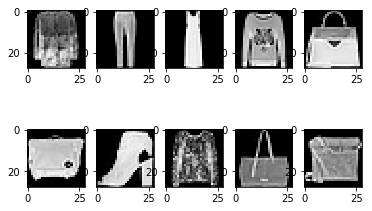

In [7]:
"""
We can visualize some of our training data using matplotlib. Visualization is optional but highly recommended.
"""
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

fig = plt.figure()
gs = gridspec.GridSpec(2, 5)

for i in np.arange(10):
    """ Pick a random sample from the loaded set of images and display using matplotlib """
    sample_idx = np.random.randint(len(train_X))
    sample_img = train_X[sample_idx, :].reshape(28, 28)
    
    fig.add_subplot(gs[i])
    plt.imshow(sample_img, cmap='gray')

### Our Model

Our model is a 2 layer ConvNet. Each conv layer is followed by a max pooling layer. Finally, we are using one dense layer for classification. To make sure our model does not overfit, we are using a dropout.

Graphically, our model looks something like this:

![conv_net](./convnet_fig.png)

In [8]:
def cnn_model_fn_1(features, labels, mode):
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn_1, model_dir="./mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3635474b90>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './mnist_convnet_model', '_save_summary_steps': 100}


In [10]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_X},
    y=train_y,
    batch_size=400,
    num_epochs=None,
    shuffle=True)

In [11]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_X},
    y=test_y,
    num_epochs=1,
    shuffle=False)

In [12]:
for j in range(100):
    mnist_classifier.train(input_fn=train_input_fn, steps=2000)

    eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 2.315049, step = 1
INFO:tensorflow:global_step/sec: 76.0531
INFO:tensorflow:loss = 2.2689018, step = 101 (1.317 sec)
INFO:tensorflow:global_step/sec: 78.4938
INFO:tensorflow:loss = 2.2226267, step = 201 (1.274 sec)
INFO:tensorflow:global_step/sec: 79.3723
INFO:tensorflow:loss = 2.1780584, step = 301 (1.260 sec)
INFO:tensorflow:global_step/sec: 78.3602
INFO:tensorflow:loss = 2.0703583, step = 401 (1.276 sec)
INFO:tensorflow:global_step/sec: 75.1039
INFO:tensorflow:loss = 1.920774, step = 501 (1.332 sec)
INFO:tensorflow:global_step/sec: 78.3493
INFO:tensorflow:loss = 1.7601731, step = 601 (1.276 sec)
INFO:tensorflow:global_step/sec: 78.1973
INFO:tensorflow:loss = 1.5608625, step = 701 (1.279 sec)
INFO:tensorflow:global_step/sec: 77.7681
INFO:tensorflow:loss = 1.3468677, step = 801 (1.286 sec)
INFO:tensorflow:global_step/sec: 76.2424
INFO:tenso

INFO:tensorflow:loss = 0.6955885, step = 6201 (1.359 sec)
INFO:tensorflow:global_step/sec: 73.2158
INFO:tensorflow:loss = 0.6903336, step = 6301 (1.365 sec)
INFO:tensorflow:global_step/sec: 73.2591
INFO:tensorflow:loss = 0.5679, step = 6401 (1.366 sec)
INFO:tensorflow:global_step/sec: 73.2107
INFO:tensorflow:loss = 0.6153691, step = 6501 (1.365 sec)
INFO:tensorflow:global_step/sec: 73.2281
INFO:tensorflow:loss = 0.6260459, step = 6601 (1.366 sec)
INFO:tensorflow:global_step/sec: 73.8982
INFO:tensorflow:loss = 0.59246564, step = 6701 (1.353 sec)
INFO:tensorflow:global_step/sec: 72.8355
INFO:tensorflow:loss = 0.5839585, step = 6801 (1.374 sec)
INFO:tensorflow:global_step/sec: 73.2098
INFO:tensorflow:loss = 0.66786367, step = 6901 (1.365 sec)
INFO:tensorflow:global_step/sec: 71.7464
INFO:tensorflow:loss = 0.62457174, step = 7001 (1.394 sec)
INFO:tensorflow:global_step/sec: 72.6108
INFO:tensorflow:loss = 0.61128706, step = 7101 (1.378 sec)
INFO:tensorflow:global_step/sec: 73.2124
INFO:tens

INFO:tensorflow:global_step/sec: 72.2589
INFO:tensorflow:loss = 0.5148497, step = 12501 (1.383 sec)
INFO:tensorflow:global_step/sec: 74.0132
INFO:tensorflow:loss = 0.51613986, step = 12601 (1.352 sec)
INFO:tensorflow:global_step/sec: 74.2375
INFO:tensorflow:loss = 0.52283984, step = 12701 (1.347 sec)
INFO:tensorflow:global_step/sec: 75.52
INFO:tensorflow:loss = 0.51141846, step = 12801 (1.324 sec)
INFO:tensorflow:global_step/sec: 74.1313
INFO:tensorflow:loss = 0.50431746, step = 12901 (1.349 sec)
INFO:tensorflow:global_step/sec: 73.3044
INFO:tensorflow:loss = 0.4905323, step = 13001 (1.365 sec)
INFO:tensorflow:global_step/sec: 74.6596
INFO:tensorflow:loss = 0.518386, step = 13101 (1.339 sec)
INFO:tensorflow:global_step/sec: 74.2614
INFO:tensorflow:loss = 0.5047755, step = 13201 (1.346 sec)
INFO:tensorflow:global_step/sec: 74.7739
INFO:tensorflow:loss = 0.54277, step = 13301 (1.337 sec)
INFO:tensorflow:global_step/sec: 76.6866
INFO:tensorflow:loss = 0.52304345, step = 13401 (1.305 sec)


INFO:tensorflow:global_step/sec: 74.3192
INFO:tensorflow:loss = 0.46103287, step = 18701 (1.346 sec)
INFO:tensorflow:global_step/sec: 73.8896
INFO:tensorflow:loss = 0.5029467, step = 18801 (1.354 sec)
INFO:tensorflow:global_step/sec: 73.3354
INFO:tensorflow:loss = 0.45738164, step = 18901 (1.363 sec)
INFO:tensorflow:global_step/sec: 74.8911
INFO:tensorflow:loss = 0.46935022, step = 19001 (1.336 sec)
INFO:tensorflow:global_step/sec: 75.1116
INFO:tensorflow:loss = 0.46663705, step = 19101 (1.331 sec)
INFO:tensorflow:global_step/sec: 73.9135
INFO:tensorflow:loss = 0.41961342, step = 19201 (1.353 sec)
INFO:tensorflow:global_step/sec: 74.045
INFO:tensorflow:loss = 0.49453202, step = 19301 (1.352 sec)
INFO:tensorflow:global_step/sec: 73.7151
INFO:tensorflow:loss = 0.4845991, step = 19401 (1.356 sec)
INFO:tensorflow:global_step/sec: 74.3599
INFO:tensorflow:loss = 0.4481538, step = 19501 (1.344 sec)
INFO:tensorflow:global_step/sec: 72.877
INFO:tensorflow:loss = 0.46076402, step = 19601 (1.372 

INFO:tensorflow:global_step/sec: 72.8592
INFO:tensorflow:loss = 0.4297322, step = 24901 (1.373 sec)
INFO:tensorflow:global_step/sec: 73.5861
INFO:tensorflow:loss = 0.41680226, step = 25001 (1.359 sec)
INFO:tensorflow:global_step/sec: 73.3858
INFO:tensorflow:loss = 0.42494527, step = 25101 (1.362 sec)
INFO:tensorflow:global_step/sec: 72.1777
INFO:tensorflow:loss = 0.39794618, step = 25201 (1.386 sec)
INFO:tensorflow:global_step/sec: 74.131
INFO:tensorflow:loss = 0.4056831, step = 25301 (1.348 sec)
INFO:tensorflow:global_step/sec: 74.3931
INFO:tensorflow:loss = 0.49100807, step = 25401 (1.345 sec)
INFO:tensorflow:global_step/sec: 71.8726
INFO:tensorflow:loss = 0.41275397, step = 25501 (1.391 sec)
INFO:tensorflow:global_step/sec: 73.8063
INFO:tensorflow:loss = 0.3947957, step = 25601 (1.355 sec)
INFO:tensorflow:global_step/sec: 74.5303
INFO:tensorflow:loss = 0.4641592, step = 25701 (1.341 sec)
INFO:tensorflow:global_step/sec: 73.012
INFO:tensorflow:loss = 0.43130013, step = 25801 (1.371 s

INFO:tensorflow:global_step/sec: 73.3606
INFO:tensorflow:loss = 0.39531013, step = 31101 (1.363 sec)
INFO:tensorflow:global_step/sec: 72.2531
INFO:tensorflow:loss = 0.31388685, step = 31201 (1.384 sec)
INFO:tensorflow:global_step/sec: 73.0673
INFO:tensorflow:loss = 0.40526414, step = 31301 (1.368 sec)
INFO:tensorflow:global_step/sec: 72.5373
INFO:tensorflow:loss = 0.43713814, step = 31401 (1.379 sec)
INFO:tensorflow:global_step/sec: 73.8189
INFO:tensorflow:loss = 0.38543493, step = 31501 (1.355 sec)
INFO:tensorflow:global_step/sec: 73.6822
INFO:tensorflow:loss = 0.36544028, step = 31601 (1.358 sec)
INFO:tensorflow:global_step/sec: 72.4219
INFO:tensorflow:loss = 0.4448061, step = 31701 (1.381 sec)
INFO:tensorflow:global_step/sec: 74.0085
INFO:tensorflow:loss = 0.30609763, step = 31801 (1.351 sec)
INFO:tensorflow:global_step/sec: 73.8818
INFO:tensorflow:loss = 0.34012657, step = 31901 (1.353 sec)
INFO:tensorflow:Saving checkpoints for 32000 into ./mnist_convnet_model/model.ckpt.
INFO:ten

INFO:tensorflow:global_step/sec: 76.3111
INFO:tensorflow:loss = 0.39895505, step = 37301 (1.311 sec)
INFO:tensorflow:global_step/sec: 75.4376
INFO:tensorflow:loss = 0.3565817, step = 37401 (1.326 sec)
INFO:tensorflow:global_step/sec: 72.6017
INFO:tensorflow:loss = 0.3812136, step = 37501 (1.377 sec)
INFO:tensorflow:global_step/sec: 70.5919
INFO:tensorflow:loss = 0.35506272, step = 37601 (1.417 sec)
INFO:tensorflow:global_step/sec: 71.3669
INFO:tensorflow:loss = 0.37778896, step = 37701 (1.401 sec)
INFO:tensorflow:global_step/sec: 71.5002
INFO:tensorflow:loss = 0.39811516, step = 37801 (1.398 sec)
INFO:tensorflow:global_step/sec: 71.5192
INFO:tensorflow:loss = 0.36605808, step = 37901 (1.399 sec)
INFO:tensorflow:Saving checkpoints for 38000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.38123944.
INFO:tensorflow:Starting evaluation at 2018-02-20-11:38:18
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-38000
INFO:tensorflow:Finish

INFO:tensorflow:global_step/sec: 74.532
INFO:tensorflow:loss = 0.3924174, step = 43501 (1.341 sec)
INFO:tensorflow:global_step/sec: 73.3751
INFO:tensorflow:loss = 0.38028535, step = 43601 (1.364 sec)
INFO:tensorflow:global_step/sec: 74.29
INFO:tensorflow:loss = 0.377641, step = 43701 (1.346 sec)
INFO:tensorflow:global_step/sec: 74.4251
INFO:tensorflow:loss = 0.39665735, step = 43801 (1.344 sec)
INFO:tensorflow:global_step/sec: 74.0894
INFO:tensorflow:loss = 0.3536697, step = 43901 (1.350 sec)
INFO:tensorflow:Saving checkpoints for 44000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.41559494.
INFO:tensorflow:Starting evaluation at 2018-02-20-11:39:42
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-44000
INFO:tensorflow:Finished evaluation at 2018-02-20-11:39:42
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.8663, global_step = 44000, loss = 0.37930357
{'loss': 0.37930357, 'global_step': 44000, 'accuracy': 0.8663

INFO:tensorflow:global_step/sec: 73.3044
INFO:tensorflow:loss = 0.25874597, step = 49701 (1.364 sec)
INFO:tensorflow:global_step/sec: 74.0268
INFO:tensorflow:loss = 0.32649648, step = 49801 (1.351 sec)
INFO:tensorflow:global_step/sec: 73.4089
INFO:tensorflow:loss = 0.39697284, step = 49901 (1.362 sec)
INFO:tensorflow:Saving checkpoints for 50000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.31752816.
INFO:tensorflow:Starting evaluation at 2018-02-20-11:41:06
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-50000
INFO:tensorflow:Finished evaluation at 2018-02-20-11:41:07
INFO:tensorflow:Saving dict for global step 50000: accuracy = 0.8685, global_step = 50000, loss = 0.36799476
{'loss': 0.36799476, 'global_step': 50000, 'accuracy': 0.8685}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-50000
INFO:tensorflow:Saving checkpoints for 50001 into ./mnist_convnet_mo

INFO:tensorflow:global_step/sec: 73.8212
INFO:tensorflow:loss = 0.34560996, step = 55901 (1.354 sec)
INFO:tensorflow:Saving checkpoints for 56000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.32730925.
INFO:tensorflow:Starting evaluation at 2018-02-20-11:42:31
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-56000
INFO:tensorflow:Finished evaluation at 2018-02-20-11:42:32
INFO:tensorflow:Saving dict for global step 56000: accuracy = 0.8716, global_step = 56000, loss = 0.36115125
{'loss': 0.36115125, 'global_step': 56000, 'accuracy': 0.8716}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-56000
INFO:tensorflow:Saving checkpoints for 56001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.36015138, step = 56001
INFO:tensorflow:global_step/sec: 73.225
INFO:tensorflow:loss = 0.3683769, step = 56101 (1.367 sec)
INFO:tensorflow:global_step/sec: 77.536

INFO:tensorflow:Starting evaluation at 2018-02-20-11:43:56
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-62000
INFO:tensorflow:Finished evaluation at 2018-02-20-11:43:57
INFO:tensorflow:Saving dict for global step 62000: accuracy = 0.8726, global_step = 62000, loss = 0.35315838
{'loss': 0.35315838, 'global_step': 62000, 'accuracy': 0.8726}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-62000
INFO:tensorflow:Saving checkpoints for 62001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.37185535, step = 62001
INFO:tensorflow:global_step/sec: 73.0561
INFO:tensorflow:loss = 0.37710458, step = 62101 (1.370 sec)
INFO:tensorflow:global_step/sec: 75.5811
INFO:tensorflow:loss = 0.31855774, step = 62201 (1.324 sec)
INFO:tensorflow:global_step/sec: 74.6419
INFO:tensorflow:loss = 0.32410923, step = 62301 (1.339 sec)
INFO:tensorflow:global_step/sec: 73.5536
INFO:tensorflow:loss = 0.355

INFO:tensorflow:Saving dict for global step 68000: accuracy = 0.8753, global_step = 68000, loss = 0.3477146
{'loss': 0.3477146, 'global_step': 68000, 'accuracy': 0.8753}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-68000
INFO:tensorflow:Saving checkpoints for 68001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.30654782, step = 68001
INFO:tensorflow:global_step/sec: 74.1863
INFO:tensorflow:loss = 0.34331262, step = 68101 (1.350 sec)
INFO:tensorflow:global_step/sec: 75.8672
INFO:tensorflow:loss = 0.27866742, step = 68201 (1.319 sec)
INFO:tensorflow:global_step/sec: 74.3242
INFO:tensorflow:loss = 0.29395312, step = 68301 (1.344 sec)
INFO:tensorflow:global_step/sec: 73.5482
INFO:tensorflow:loss = 0.34306768, step = 68401 (1.360 sec)
INFO:tensorflow:global_step/sec: 71.2796
INFO:tensorflow:loss = 0.3874053, step = 68501 (1.402 sec)
INFO:tensorflow:global_step/sec: 71.592
INFO:tensorflow:loss = 0.2609

INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-74000
INFO:tensorflow:Saving checkpoints for 74001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.29066193, step = 74001
INFO:tensorflow:global_step/sec: 75.1579
INFO:tensorflow:loss = 0.32027325, step = 74101 (1.333 sec)
INFO:tensorflow:global_step/sec: 75.6838
INFO:tensorflow:loss = 0.26165882, step = 74201 (1.321 sec)
INFO:tensorflow:global_step/sec: 73.5683
INFO:tensorflow:loss = 0.26285684, step = 74301 (1.359 sec)
INFO:tensorflow:global_step/sec: 72.7207
INFO:tensorflow:loss = 0.31987497, step = 74401 (1.375 sec)
INFO:tensorflow:global_step/sec: 72.2363
INFO:tensorflow:loss = 0.29900116, step = 74501 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.432
INFO:tensorflow:loss = 0.27336216, step = 74601 (1.381 sec)
INFO:tensorflow:global_step/sec: 73.1847
INFO:tensorflow:loss = 0.34052226, step = 74701 (1.367 sec)
INFO:tensorflow:global_step/sec: 71.278
INFO:tensorflow:loss = 0.25645363, step =

INFO:tensorflow:global_step/sec: 72.9109
INFO:tensorflow:loss = 0.29135728, step = 80101 (1.374 sec)
INFO:tensorflow:global_step/sec: 74.1823
INFO:tensorflow:loss = 0.27467218, step = 80201 (1.348 sec)
INFO:tensorflow:global_step/sec: 72.2657
INFO:tensorflow:loss = 0.34341645, step = 80301 (1.385 sec)
INFO:tensorflow:global_step/sec: 73.3319
INFO:tensorflow:loss = 0.30079123, step = 80401 (1.364 sec)
INFO:tensorflow:global_step/sec: 71.9894
INFO:tensorflow:loss = 0.2800548, step = 80501 (1.388 sec)
INFO:tensorflow:global_step/sec: 73.0559
INFO:tensorflow:loss = 0.30677482, step = 80601 (1.370 sec)
INFO:tensorflow:global_step/sec: 72.2964
INFO:tensorflow:loss = 0.3204733, step = 80701 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.1811
INFO:tensorflow:loss = 0.3246495, step = 80801 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.6266
INFO:tensorflow:loss = 0.3126946, step = 80901 (1.378 sec)
INFO:tensorflow:global_step/sec: 73.7638
INFO:tensorflow:loss = 0.30290937, step = 81001 (1.356

INFO:tensorflow:global_step/sec: 73.3819
INFO:tensorflow:loss = 0.3333308, step = 86301 (1.363 sec)
INFO:tensorflow:global_step/sec: 72.392
INFO:tensorflow:loss = 0.30598226, step = 86401 (1.382 sec)
INFO:tensorflow:global_step/sec: 72.7576
INFO:tensorflow:loss = 0.29156423, step = 86501 (1.373 sec)
INFO:tensorflow:global_step/sec: 72.4808
INFO:tensorflow:loss = 0.28298777, step = 86601 (1.381 sec)
INFO:tensorflow:global_step/sec: 72.2153
INFO:tensorflow:loss = 0.29585087, step = 86701 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.382
INFO:tensorflow:loss = 0.27341467, step = 86801 (1.383 sec)
INFO:tensorflow:global_step/sec: 73.7197
INFO:tensorflow:loss = 0.33164117, step = 86901 (1.357 sec)
INFO:tensorflow:global_step/sec: 73.1642
INFO:tensorflow:loss = 0.27746785, step = 87001 (1.366 sec)
INFO:tensorflow:global_step/sec: 74.0309
INFO:tensorflow:loss = 0.3043571, step = 87101 (1.351 sec)
INFO:tensorflow:global_step/sec: 72.5453
INFO:tensorflow:loss = 0.34894523, step = 87201 (1.378

INFO:tensorflow:global_step/sec: 72.8726
INFO:tensorflow:loss = 0.28885812, step = 92501 (1.373 sec)
INFO:tensorflow:global_step/sec: 72.3311
INFO:tensorflow:loss = 0.29485497, step = 92601 (1.383 sec)
INFO:tensorflow:global_step/sec: 72.2644
INFO:tensorflow:loss = 0.2753962, step = 92701 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.7572
INFO:tensorflow:loss = 0.28016555, step = 92801 (1.374 sec)
INFO:tensorflow:global_step/sec: 72.1889
INFO:tensorflow:loss = 0.2896822, step = 92901 (1.385 sec)
INFO:tensorflow:global_step/sec: 72.2587
INFO:tensorflow:loss = 0.301369, step = 93001 (1.383 sec)
INFO:tensorflow:global_step/sec: 73.704
INFO:tensorflow:loss = 0.30754644, step = 93101 (1.357 sec)
INFO:tensorflow:global_step/sec: 71.9114
INFO:tensorflow:loss = 0.27104414, step = 93201 (1.391 sec)
INFO:tensorflow:global_step/sec: 72.597
INFO:tensorflow:loss = 0.27814117, step = 93301 (1.377 sec)
INFO:tensorflow:global_step/sec: 73.2953
INFO:tensorflow:loss = 0.32129946, step = 93401 (1.365 s

INFO:tensorflow:global_step/sec: 72.3595
INFO:tensorflow:loss = 0.2626095, step = 98701 (1.382 sec)
INFO:tensorflow:global_step/sec: 71.8647
INFO:tensorflow:loss = 0.27152345, step = 98801 (1.391 sec)
INFO:tensorflow:global_step/sec: 72.2003
INFO:tensorflow:loss = 0.29203472, step = 98901 (1.385 sec)
INFO:tensorflow:global_step/sec: 72.4196
INFO:tensorflow:loss = 0.26852286, step = 99001 (1.381 sec)
INFO:tensorflow:global_step/sec: 71.32
INFO:tensorflow:loss = 0.32881868, step = 99101 (1.402 sec)
INFO:tensorflow:global_step/sec: 71.9234
INFO:tensorflow:loss = 0.3210636, step = 99201 (1.390 sec)
INFO:tensorflow:global_step/sec: 71.6613
INFO:tensorflow:loss = 0.3192173, step = 99301 (1.395 sec)
INFO:tensorflow:global_step/sec: 71.7084
INFO:tensorflow:loss = 0.32246113, step = 99401 (1.395 sec)
INFO:tensorflow:global_step/sec: 73.2303
INFO:tensorflow:loss = 0.26981294, step = 99501 (1.365 sec)
INFO:tensorflow:global_step/sec: 73.8372
INFO:tensorflow:loss = 0.28343505, step = 99601 (1.354 

INFO:tensorflow:loss = 0.27935287, step = 104801 (1.361 sec)
INFO:tensorflow:global_step/sec: 72.6564
INFO:tensorflow:loss = 0.32018435, step = 104901 (1.376 sec)
INFO:tensorflow:global_step/sec: 72.4229
INFO:tensorflow:loss = 0.31476668, step = 105001 (1.381 sec)
INFO:tensorflow:global_step/sec: 72.3834
INFO:tensorflow:loss = 0.28050983, step = 105101 (1.382 sec)
INFO:tensorflow:global_step/sec: 71.7488
INFO:tensorflow:loss = 0.30532998, step = 105201 (1.393 sec)
INFO:tensorflow:global_step/sec: 72.2853
INFO:tensorflow:loss = 0.26817837, step = 105301 (1.383 sec)
INFO:tensorflow:global_step/sec: 72.1595
INFO:tensorflow:loss = 0.28537562, step = 105401 (1.386 sec)
INFO:tensorflow:global_step/sec: 72.744
INFO:tensorflow:loss = 0.34987235, step = 105501 (1.375 sec)
INFO:tensorflow:global_step/sec: 72.458
INFO:tensorflow:loss = 0.2661276, step = 105601 (1.380 sec)
INFO:tensorflow:global_step/sec: 72.9876
INFO:tensorflow:loss = 0.29481366, step = 105701 (1.370 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 71.9246
INFO:tensorflow:loss = 0.31570315, step = 111001 (1.391 sec)
INFO:tensorflow:global_step/sec: 72.854
INFO:tensorflow:loss = 0.2725319, step = 111101 (1.372 sec)
INFO:tensorflow:global_step/sec: 72.1602
INFO:tensorflow:loss = 0.27727374, step = 111201 (1.386 sec)
INFO:tensorflow:global_step/sec: 71.6579
INFO:tensorflow:loss = 0.29733714, step = 111301 (1.395 sec)
INFO:tensorflow:global_step/sec: 71.8835
INFO:tensorflow:loss = 0.26845077, step = 111401 (1.392 sec)
INFO:tensorflow:global_step/sec: 73.0997
INFO:tensorflow:loss = 0.2413508, step = 111501 (1.367 sec)
INFO:tensorflow:global_step/sec: 73.0724
INFO:tensorflow:loss = 0.24786657, step = 111601 (1.369 sec)
INFO:tensorflow:global_step/sec: 71.1567
INFO:tensorflow:loss = 0.2599271, step = 111701 (1.405 sec)
INFO:tensorflow:global_step/sec: 71.5784
INFO:tensorflow:loss = 0.2813798, step = 111801 (1.398 sec)
INFO:tensorflow:global_step/sec: 73.0221
INFO:tensorflow:loss = 0.28391495, step = 1119

INFO:tensorflow:loss = 0.2690424, step = 117101 (1.385 sec)
INFO:tensorflow:global_step/sec: 71.7025
INFO:tensorflow:loss = 0.19820777, step = 117201 (1.394 sec)
INFO:tensorflow:global_step/sec: 72.4639
INFO:tensorflow:loss = 0.2990404, step = 117301 (1.380 sec)
INFO:tensorflow:global_step/sec: 72.1701
INFO:tensorflow:loss = 0.26558447, step = 117401 (1.386 sec)
INFO:tensorflow:global_step/sec: 72.5699
INFO:tensorflow:loss = 0.25844276, step = 117501 (1.377 sec)
INFO:tensorflow:global_step/sec: 72.7457
INFO:tensorflow:loss = 0.24031271, step = 117601 (1.375 sec)
INFO:tensorflow:global_step/sec: 72.3168
INFO:tensorflow:loss = 0.26790157, step = 117701 (1.382 sec)
INFO:tensorflow:global_step/sec: 72.0561
INFO:tensorflow:loss = 0.28569195, step = 117801 (1.388 sec)
INFO:tensorflow:global_step/sec: 72.5515
INFO:tensorflow:loss = 0.2896929, step = 117901 (1.379 sec)
INFO:tensorflow:Saving checkpoints for 118000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.31

INFO:tensorflow:loss = 0.23727995, step = 123201 (1.385 sec)
INFO:tensorflow:global_step/sec: 71.2122
INFO:tensorflow:loss = 0.2411294, step = 123301 (1.404 sec)
INFO:tensorflow:global_step/sec: 70.5209
INFO:tensorflow:loss = 0.2193573, step = 123401 (1.418 sec)
INFO:tensorflow:global_step/sec: 72.1255
INFO:tensorflow:loss = 0.23920278, step = 123501 (1.386 sec)
INFO:tensorflow:global_step/sec: 70.9737
INFO:tensorflow:loss = 0.3030392, step = 123601 (1.409 sec)
INFO:tensorflow:global_step/sec: 72.4538
INFO:tensorflow:loss = 0.32944843, step = 123701 (1.380 sec)
INFO:tensorflow:global_step/sec: 71.1806
INFO:tensorflow:loss = 0.3057058, step = 123801 (1.405 sec)
INFO:tensorflow:global_step/sec: 71.929
INFO:tensorflow:loss = 0.2415005, step = 123901 (1.390 sec)
INFO:tensorflow:Saving checkpoints for 124000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.24265583.
INFO:tensorflow:Starting evaluation at 2018-02-20-11:58:44
INFO:tensorflow:Restoring parameters f

INFO:tensorflow:loss = 0.24631958, step = 129301 (1.374 sec)
INFO:tensorflow:global_step/sec: 72.3463
INFO:tensorflow:loss = 0.22903481, step = 129401 (1.382 sec)
INFO:tensorflow:global_step/sec: 71.9491
INFO:tensorflow:loss = 0.23155832, step = 129501 (1.390 sec)
INFO:tensorflow:global_step/sec: 72.2884
INFO:tensorflow:loss = 0.16889054, step = 129601 (1.384 sec)
INFO:tensorflow:global_step/sec: 72.3233
INFO:tensorflow:loss = 0.26670596, step = 129701 (1.382 sec)
INFO:tensorflow:global_step/sec: 72.9759
INFO:tensorflow:loss = 0.25446856, step = 129801 (1.370 sec)
INFO:tensorflow:global_step/sec: 72.519
INFO:tensorflow:loss = 0.20358972, step = 129901 (1.379 sec)
INFO:tensorflow:Saving checkpoints for 130000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.20623262.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:00:10
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-130000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:

INFO:tensorflow:global_step/sec: 70.3954
INFO:tensorflow:loss = 0.21174385, step = 135501 (1.421 sec)
INFO:tensorflow:global_step/sec: 71.0921
INFO:tensorflow:loss = 0.30072978, step = 135601 (1.406 sec)
INFO:tensorflow:global_step/sec: 69.3204
INFO:tensorflow:loss = 0.22180358, step = 135701 (1.443 sec)
INFO:tensorflow:global_step/sec: 70.1881
INFO:tensorflow:loss = 0.24499281, step = 135801 (1.425 sec)
INFO:tensorflow:global_step/sec: 69.8591
INFO:tensorflow:loss = 0.28356063, step = 135901 (1.431 sec)
INFO:tensorflow:Saving checkpoints for 136000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2143861.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:01:37
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-136000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:01:38
INFO:tensorflow:Saving dict for global step 136000: accuracy = 0.8951, global_step = 136000, loss = 0.29791164
{'loss': 0.29791164, 'global_step': 136000, 'a

INFO:tensorflow:global_step/sec: 74.4287
INFO:tensorflow:loss = 0.28576684, step = 141601 (1.344 sec)
INFO:tensorflow:global_step/sec: 74.7315
INFO:tensorflow:loss = 0.26981238, step = 141701 (1.338 sec)
INFO:tensorflow:global_step/sec: 75.8131
INFO:tensorflow:loss = 0.26665413, step = 141801 (1.319 sec)
INFO:tensorflow:global_step/sec: 74.916
INFO:tensorflow:loss = 0.27224088, step = 141901 (1.336 sec)
INFO:tensorflow:Saving checkpoints for 142000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.27154198.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:03:03
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-142000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:03:03
INFO:tensorflow:Saving dict for global step 142000: accuracy = 0.8948, global_step = 142000, loss = 0.299284
{'loss': 0.299284, 'global_step': 142000, 'accuracy': 0.8948}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./

INFO:tensorflow:global_step/sec: 72.0409
INFO:tensorflow:loss = 0.24658734, step = 147701 (1.389 sec)
INFO:tensorflow:global_step/sec: 73.1654
INFO:tensorflow:loss = 0.27837577, step = 147801 (1.367 sec)
INFO:tensorflow:global_step/sec: 72.2469
INFO:tensorflow:loss = 0.23362492, step = 147901 (1.384 sec)
INFO:tensorflow:Saving checkpoints for 148000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.27139673.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:04:29
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-148000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:04:29
INFO:tensorflow:Saving dict for global step 148000: accuracy = 0.8973, global_step = 148000, loss = 0.29173705
{'loss': 0.29173705, 'global_step': 148000, 'accuracy': 0.8973}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-148000
INFO:tensorflow:Saving checkpoints for 148001 into ./mnist_

INFO:tensorflow:global_step/sec: 70.1416
INFO:tensorflow:loss = 0.24808195, step = 153801 (1.426 sec)
INFO:tensorflow:global_step/sec: 67.3667
INFO:tensorflow:loss = 0.19785038, step = 153901 (1.484 sec)
INFO:tensorflow:Saving checkpoints for 154000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.23901924.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:05:54
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-154000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:05:55
INFO:tensorflow:Saving dict for global step 154000: accuracy = 0.8927, global_step = 154000, loss = 0.29874203
{'loss': 0.29874203, 'global_step': 154000, 'accuracy': 0.8927}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-154000
INFO:tensorflow:Saving checkpoints for 154001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.2859305, step = 154001
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 72.5194
INFO:tensorflow:loss = 0.22046554, step = 159901 (1.380 sec)
INFO:tensorflow:Saving checkpoints for 160000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.23942333.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:07:20
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-160000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:07:21
INFO:tensorflow:Saving dict for global step 160000: accuracy = 0.8972, global_step = 160000, loss = 0.28903994
{'loss': 0.28903994, 'global_step': 160000, 'accuracy': 0.8972}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-160000
INFO:tensorflow:Saving checkpoints for 160001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.22433057, step = 160001
INFO:tensorflow:global_step/sec: 72.9648
INFO:tensorflow:loss = 0.23308711, step = 160101 (1.373 sec)
INFO:tensorflow:global_step

INFO:tensorflow:Saving checkpoints for 166000 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2518733.
INFO:tensorflow:Starting evaluation at 2018-02-20-12:08:46
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-166000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:08:46
INFO:tensorflow:Saving dict for global step 166000: accuracy = 0.8991, global_step = 166000, loss = 0.28629956
{'loss': 0.28629956, 'global_step': 166000, 'accuracy': 0.8991}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-166000
INFO:tensorflow:Saving checkpoints for 166001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.25978178, step = 166001
INFO:tensorflow:global_step/sec: 69.6865
INFO:tensorflow:loss = 0.27318898, step = 166101 (1.437 sec)
INFO:tensorflow:global_step/sec: 73.188
INFO:tensorflow:loss = 0.23392645, step = 166201 (1.366 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:Starting evaluation at 2018-02-20-12:10:12
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-172000
INFO:tensorflow:Finished evaluation at 2018-02-20-12:10:12
INFO:tensorflow:Saving dict for global step 172000: accuracy = 0.8989, global_step = 172000, loss = 0.28497654
{'loss': 0.28497654, 'global_step': 172000, 'accuracy': 0.8989}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-172000
INFO:tensorflow:Saving checkpoints for 172001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.17871365, step = 172001
INFO:tensorflow:global_step/sec: 72.9032
INFO:tensorflow:loss = 0.2748649, step = 172101 (1.374 sec)
INFO:tensorflow:global_step/sec: 75.5777
INFO:tensorflow:loss = 0.32932654, step = 172201 (1.323 sec)
INFO:tensorflow:global_step/sec: 75.5412
INFO:tensorflow:loss = 0.20384455, step = 172301 (1.324 sec)
INFO:tensorflow:global_step/sec: 74.3556
INFO:tensorflow:los

INFO:tensorflow:Finished evaluation at 2018-02-20-12:11:38
INFO:tensorflow:Saving dict for global step 178000: accuracy = 0.8986, global_step = 178000, loss = 0.28872928
{'loss': 0.28872928, 'global_step': 178000, 'accuracy': 0.8986}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-178000
INFO:tensorflow:Saving checkpoints for 178001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.22763775, step = 178001
INFO:tensorflow:global_step/sec: 72.5171
INFO:tensorflow:loss = 0.19723533, step = 178101 (1.381 sec)
INFO:tensorflow:global_step/sec: 74.1046
INFO:tensorflow:loss = 0.31920186, step = 178201 (1.348 sec)
INFO:tensorflow:global_step/sec: 73.6098
INFO:tensorflow:loss = 0.2645538, step = 178301 (1.359 sec)
INFO:tensorflow:global_step/sec: 74.1824
INFO:tensorflow:loss = 0.24881302, step = 178401 (1.348 sec)
INFO:tensorflow:global_step/sec: 73.3089
INFO:tensorflow:loss = 0.25230682, step = 178501 (1.364 se

{'loss': 0.27991349, 'global_step': 184000, 'accuracy': 0.9025}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-184000
INFO:tensorflow:Saving checkpoints for 184001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.21162757, step = 184001
INFO:tensorflow:global_step/sec: 66.679
INFO:tensorflow:loss = 0.24033007, step = 184101 (1.501 sec)
INFO:tensorflow:global_step/sec: 72.8773
INFO:tensorflow:loss = 0.21864206, step = 184201 (1.372 sec)
INFO:tensorflow:global_step/sec: 74.6652
INFO:tensorflow:loss = 0.17932762, step = 184301 (1.340 sec)
INFO:tensorflow:global_step/sec: 69.2395
INFO:tensorflow:loss = 0.23902561, step = 184401 (1.444 sec)
INFO:tensorflow:global_step/sec: 71.0226
INFO:tensorflow:loss = 0.2379583, step = 184501 (1.409 sec)
INFO:tensorflow:global_step/sec: 71.1407
INFO:tensorflow:loss = 0.23014492, step = 184601 (1.406 sec)
INFO:tensorflow:global_step/sec: 69.6822
INFO:tensorflow:loss = 0.

INFO:tensorflow:Restoring parameters from ./mnist_convnet_model/model.ckpt-190000
INFO:tensorflow:Saving checkpoints for 190001 into ./mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.21440901, step = 190001
INFO:tensorflow:global_step/sec: 73.0402
INFO:tensorflow:loss = 0.20524186, step = 190101 (1.371 sec)
INFO:tensorflow:global_step/sec: 75.3396
INFO:tensorflow:loss = 0.2509773, step = 190201 (1.327 sec)
INFO:tensorflow:global_step/sec: 74.6459
INFO:tensorflow:loss = 0.22488552, step = 190301 (1.340 sec)
INFO:tensorflow:global_step/sec: 74.8751
INFO:tensorflow:loss = 0.22842579, step = 190401 (1.335 sec)
INFO:tensorflow:global_step/sec: 76.1949
INFO:tensorflow:loss = 0.2404492, step = 190501 (1.313 sec)
INFO:tensorflow:global_step/sec: 76.3176
INFO:tensorflow:loss = 0.27606696, step = 190601 (1.311 sec)
INFO:tensorflow:global_step/sec: 74.2194
INFO:tensorflow:loss = 0.21627083, step = 190701 (1.347 sec)
INFO:tensorflow:global_step/sec: 74.3473
INFO:tensorflow:loss = 0.224771

INFO:tensorflow:loss = 0.19718353, step = 196001
INFO:tensorflow:global_step/sec: 72.8151
INFO:tensorflow:loss = 0.25010023, step = 196101 (1.376 sec)
INFO:tensorflow:global_step/sec: 75.6406
INFO:tensorflow:loss = 0.22349162, step = 196201 (1.322 sec)
INFO:tensorflow:global_step/sec: 75.7769
INFO:tensorflow:loss = 0.27328613, step = 196301 (1.320 sec)
INFO:tensorflow:global_step/sec: 74.9326
INFO:tensorflow:loss = 0.21424107, step = 196401 (1.334 sec)
INFO:tensorflow:global_step/sec: 74.0721
INFO:tensorflow:loss = 0.24503219, step = 196501 (1.351 sec)
INFO:tensorflow:global_step/sec: 72.6866
INFO:tensorflow:loss = 0.22701244, step = 196601 (1.375 sec)
INFO:tensorflow:global_step/sec: 71.0601
INFO:tensorflow:loss = 0.23035227, step = 196701 (1.407 sec)
INFO:tensorflow:global_step/sec: 70.9807
INFO:tensorflow:loss = 0.20976037, step = 196801 (1.410 sec)
INFO:tensorflow:global_step/sec: 71.8021
INFO:tensorflow:loss = 0.2374634, step = 196901 (1.392 sec)
INFO:tensorflow:global_step/sec: 7